In [ ]:
# default_exp funcs.gen_train_funcs

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# Training loop simulator learning

In [ ]:
# export
from decode_fish.imports import *
from decode_fish.funcs.matching import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.predict import *
import torch.nn.functional as F
from torch import distributions as D
from torch.utils.data import DataLoader
import torch_optimizer
from decode_fish.engine.microscope import Microscope, get_roi_filt_inds, extract_psf_roi, mic_inp_apply_inds, add_pos_noise, concat_micro_inp
from decode_fish.engine.model import UnetDecodeNoBn_2S
from decode_fish.engine.point_process import PointProcessUniform, get_phased_ints
from decode_fish.engine.gmm_loss import PointProcessGaussian
import shutil
import wandb
import kornia

from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
# from decode_fish.funcs.visualization vimport get_simulation_statistics

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
# import h5py
# out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_5_osb/'
# with h5py.File(out_dir+'images.h5', 'r') as f:
    
#     gt_bg = f['background'][()]
#     frames = f['frames'][()]

In [ ]:
def get_gent_data(cfg, microscope, dl, gt_bg=None):
    
    ret_dict = next(iter(dl))
    x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'] 
    fr_idx, zcrop, ycrop, xcrop = ret_dict['frame_idx'], ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
    
#     print([[fr_idx.item(),y.item(),x.item()] for fr_idx,y,x in zip(fr_idx, ycrop, xcrop)])
    
    if cfg.genm.microscope.col_shifts_enabled:
        zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
        zcrop, ycrop, xcrop = zcrop.flatten(), ycrop.flatten(), xcrop.flatten()
        colshift_crop = get_color_shift_inp(microscope.color_shifts, microscope.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
    else:
        zcrop, ycrop, xcrop, colshift_crop = None, None, None, None

    background = background * microscope.get_ch_mult().detach()
    x = x * microscope.get_ch_mult().detach()
     
    if gt_bg is not None:
        gt_bg = torch.cat([gt_bg[fr_idx.item():fr_idx.item()+1,:,:,y.item():y.item()+56,x.item():x.item()+56] for fr_idx,y,x in zip(fr_idx, ycrop, xcrop)], 0)
        gt_bg = gt_bg * cpu(microscope.get_ch_mult().detach())
        gt_bg = gt_bg.cuda()
    
    return x, background, gt_bg, xcrop, ycrop

def eval_gent_data(cfg, x, bg, gt_bg, model, microscope, post_proc, xcrop, ycrop):
    
    with torch.no_grad():

        out_col = []
        bg_pred = []
        bg_gts = []
        
        for i in range(len(x)):
            
            if cfg.genm.microscope.col_shifts_enabled:
                colshift_crop = get_color_shift_inp(microscope.color_shifts, microscope.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
                out_inp = model.tensor_to_dict(model(torch.concat([x[i:i+1], colshift_crop[i:i+1]], 1)))
            else:
                out_inp = model.tensor_to_dict(model(x[i:i+1]))
                
            out_col.append(post_proc.get_micro_inp(out_inp))
            bg_pred.append(out_inp['background'])

        bg_pred = torch.concat(bg_pred)
        proc_out_inp = concat_micro_inp(out_col, batch_size=1)

        ch_out_inp = microscope.get_single_ch_inputs(*proc_out_inp, ycrop=ycrop, xcrop=xcrop)
        filt_inds = get_roi_filt_inds(*ch_out_inp[0], microscope.psf.psf_volume.shape, x.shape, slice_rec=cfg.genm.exp_type.slice_rec, min_dist=12)
        print(len(ch_out_inp[1]), len(filt_inds))
        
        ch_out_inp = mic_inp_apply_inds(*ch_out_inp, filt_inds)
        
        rois = extract_psf_roi(ch_out_inp[0], x, torch.tensor([len(ch_out_inp[1]), 1,1,21,21]))
        bgs = extract_psf_roi(ch_out_inp[0], bg_pred, torch.tensor([len(ch_out_inp[1]), 1,1,21,21]))
        
        if gt_bg is not None:
            gt_bg = extract_psf_roi(ch_out_inp[0], torch.tensor(gt_bg), torch.tensor([len(ch_out_inp[1]), 1,1,21,21]))
            gt_bg = gt_bg.cuda()
        del(model)
        del(out_col)
        free_mem()
        
        psf_recs = microscope(*ch_out_inp, ret_psfs=True, add_noise=False)  
        
        
        if cfg.training.mic.mean_diff:
            mean_diff = rois.mean([1,2,3,4], keepdim=True) - (psf_recs.detach()+bgs).mean([1,2,3,4], keepdim=True)
            rois -= mean_diff
        
    return rois, bgs, proc_out_inp, filt_inds, psf_recs, gt_bg

In [ ]:
x, background, gt_background, xcrop, ycrop = get_gent_data(cfg, micro, decode_dl, None)

In [ ]:
# model = load_model_state(model, Path('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_5_osb/sl_true_gen//')/'model.pkl').cuda()

In [ ]:
rois, bgs, proc_out_inp, filt_inds, psf_recs, bgs_gt = eval_gent_data(cfg, x, background, gt_background ,model, micro, post_proc, xcrop, ycrop)

8054 1046


In [ ]:
torch.nn.functional.mse_loss(bgs_gt, bgs)

AttributeError: 'NoneType' object has no attribute 'size'

In [ ]:
# torch.save([rois, bgs, proc_out_inp, filt_inds, psf_recs, bgs_gt],'../data/test.pt')

In [ ]:
# rois, bgs, proc_out_inp, filt_inds, psf_recs, bgs_gt = torch.load('../data/test.pt')

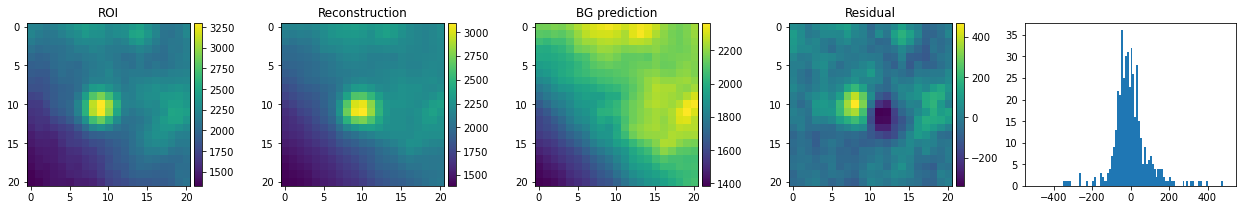

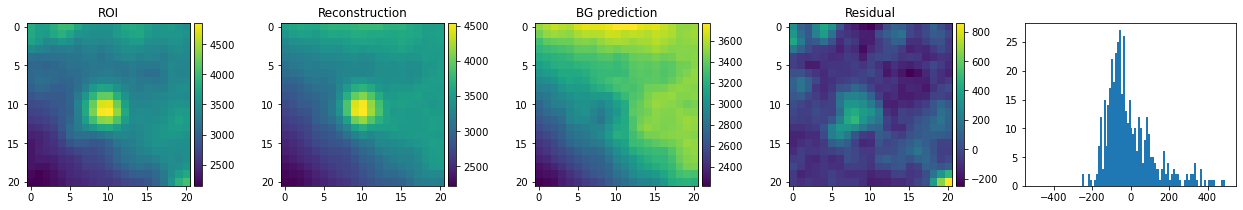

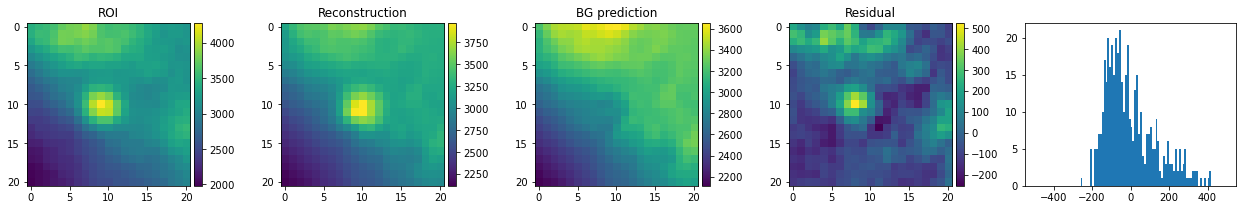

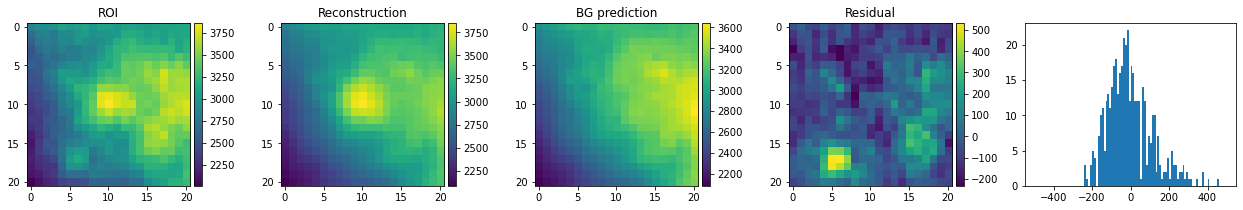

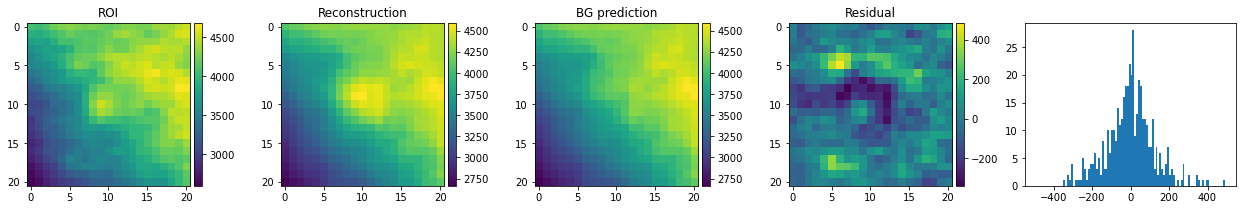

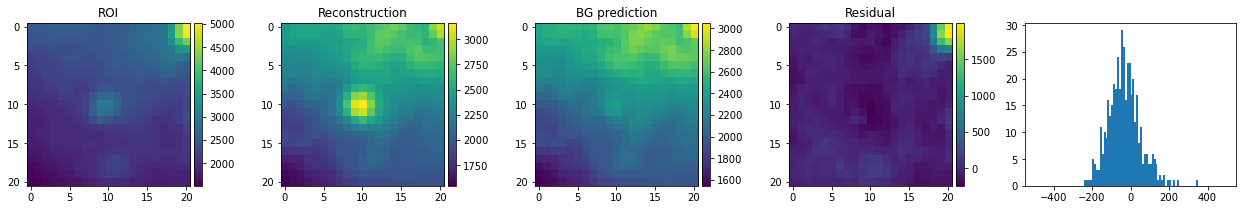

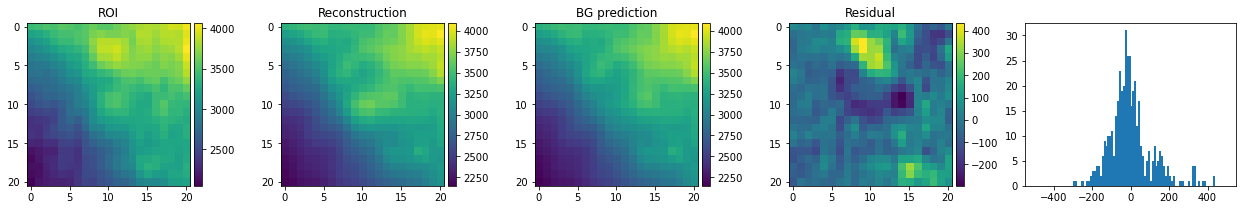

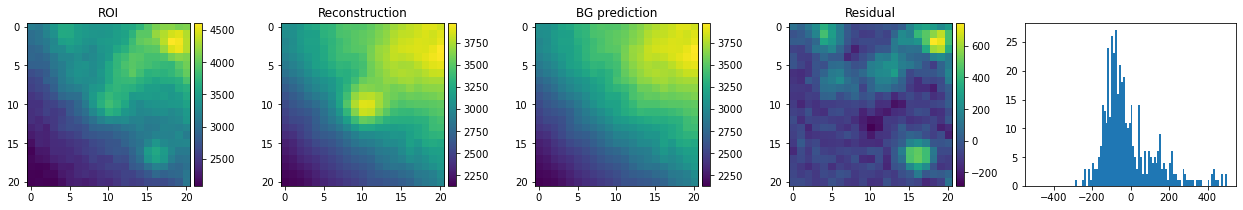

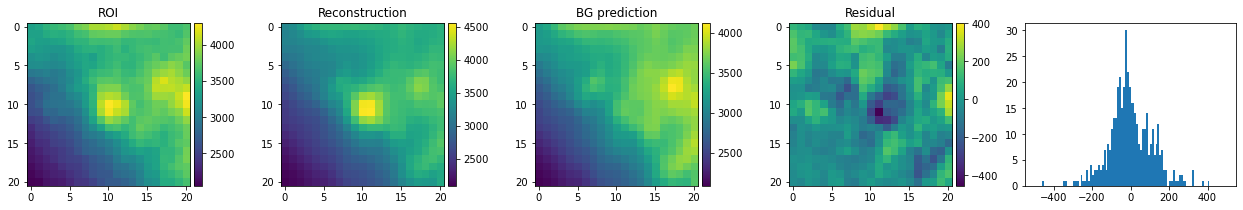

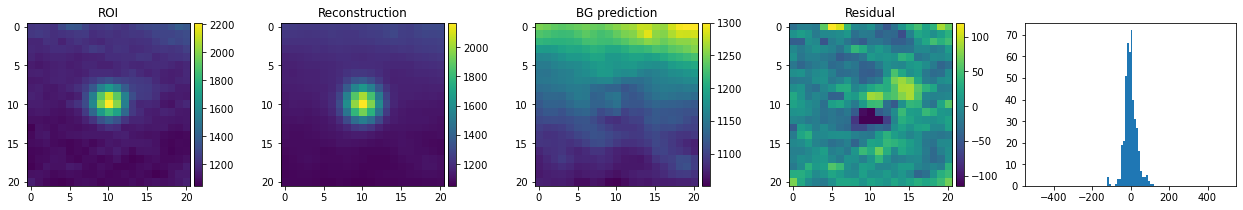

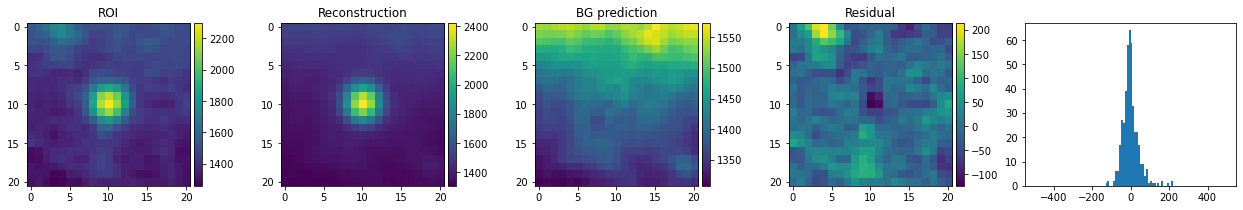

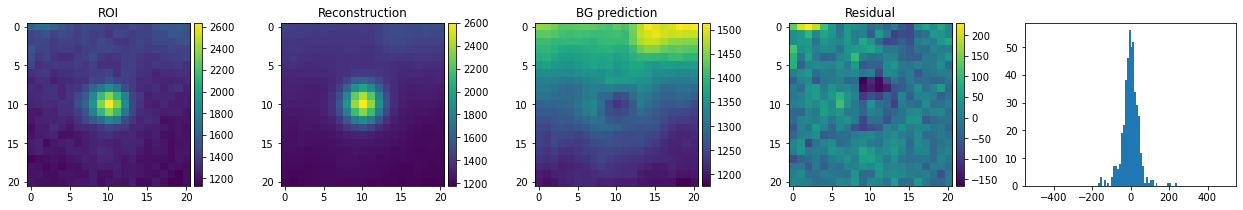

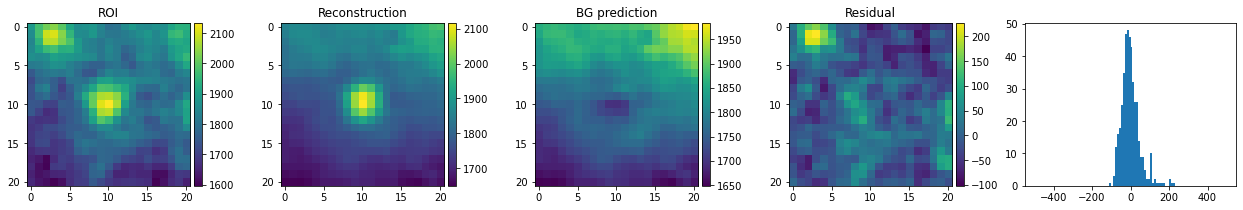

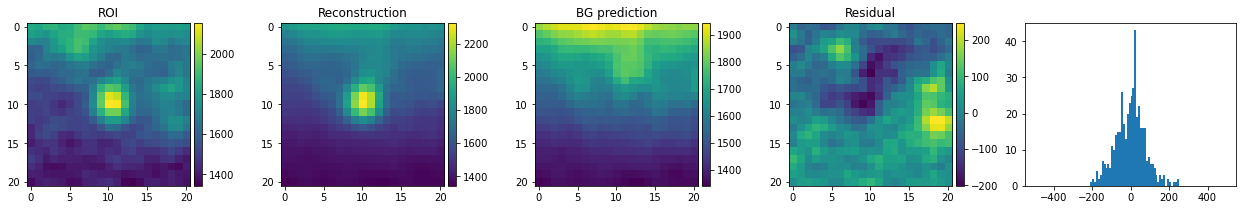

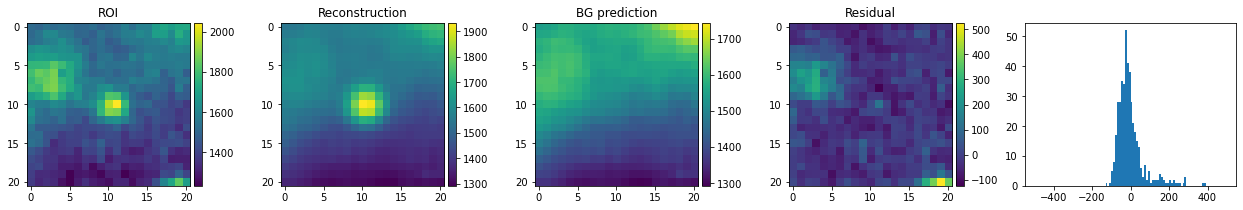

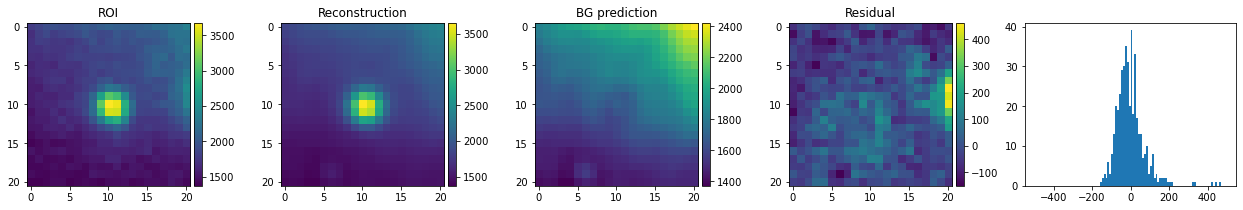

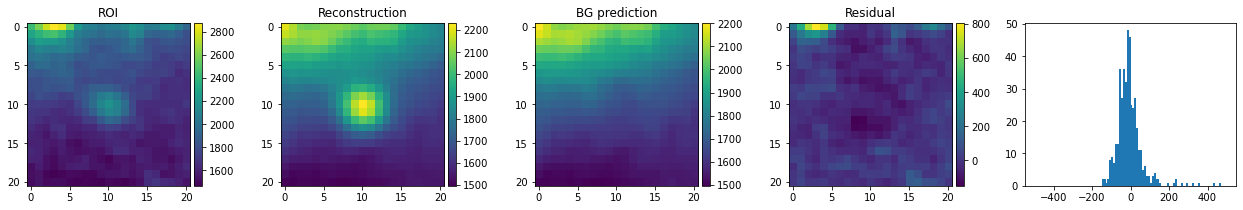

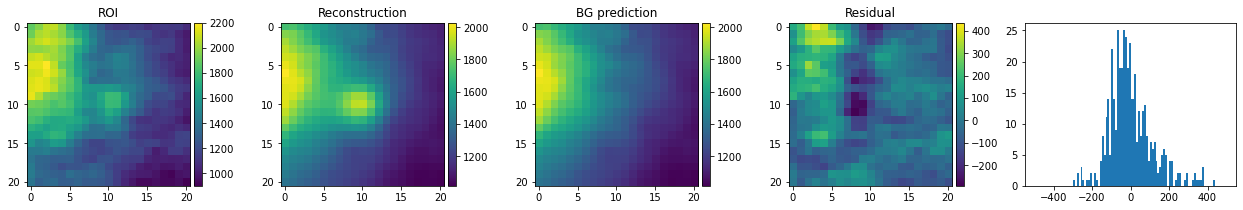

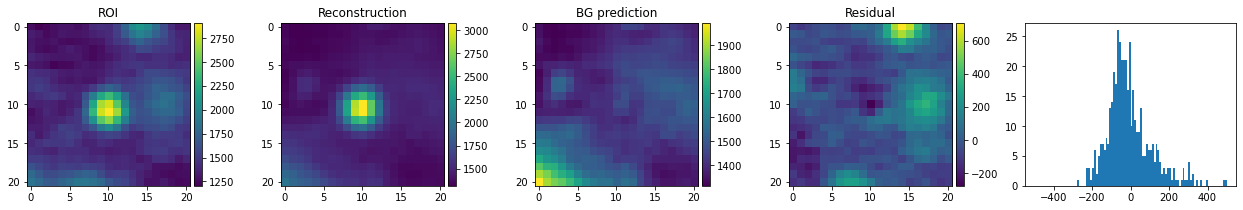

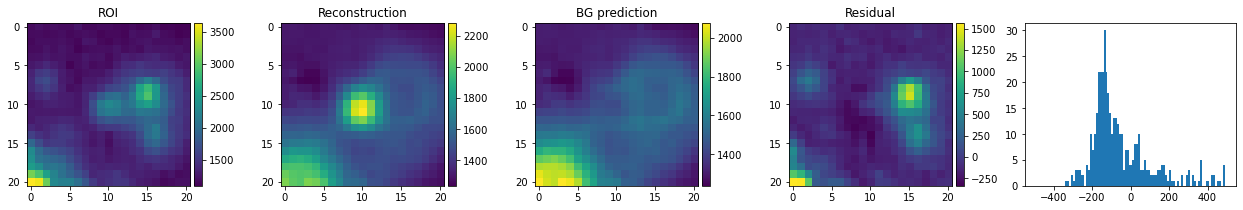

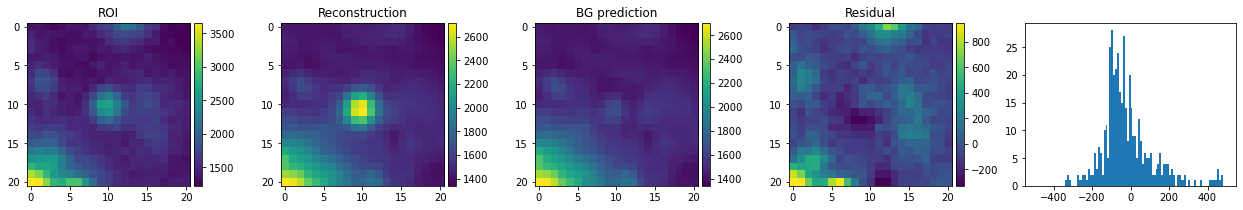

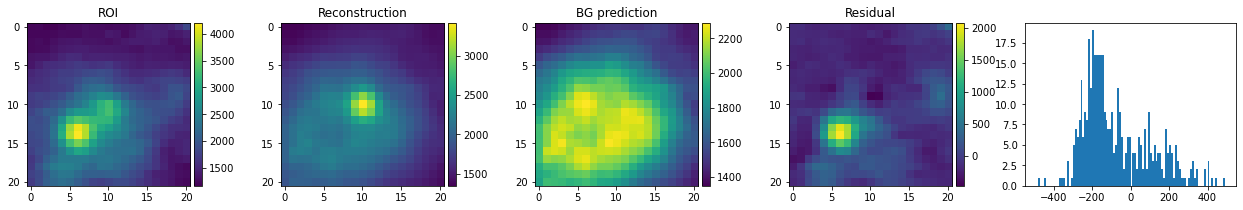

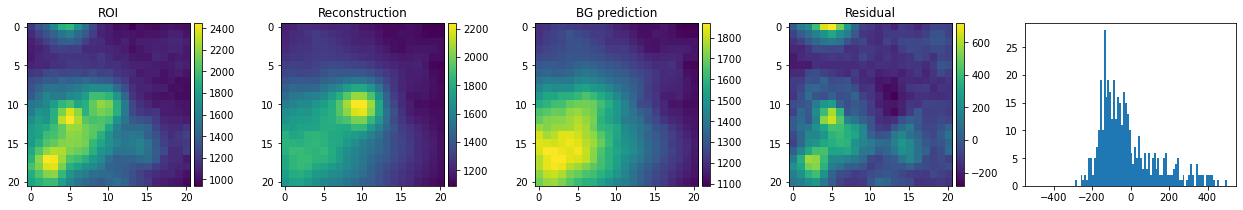

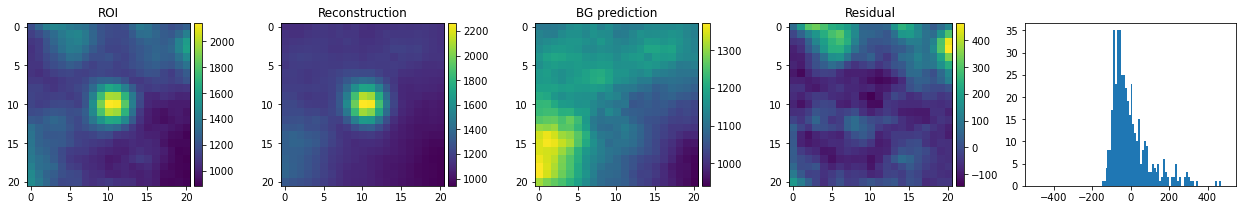

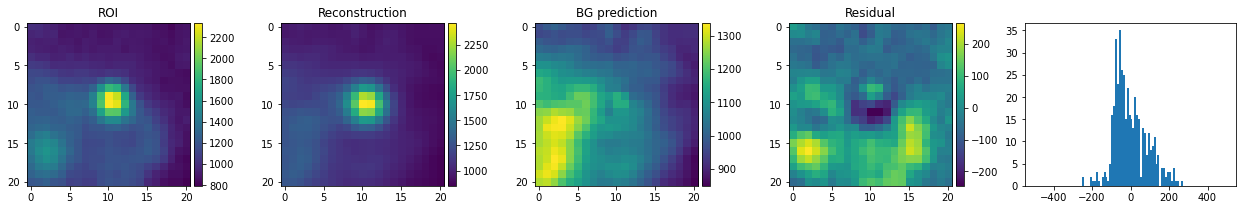

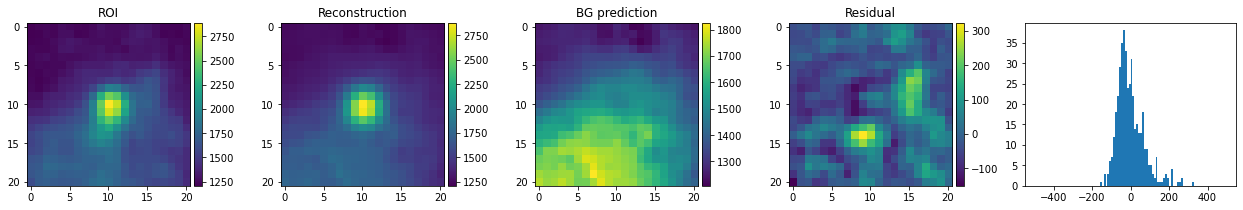

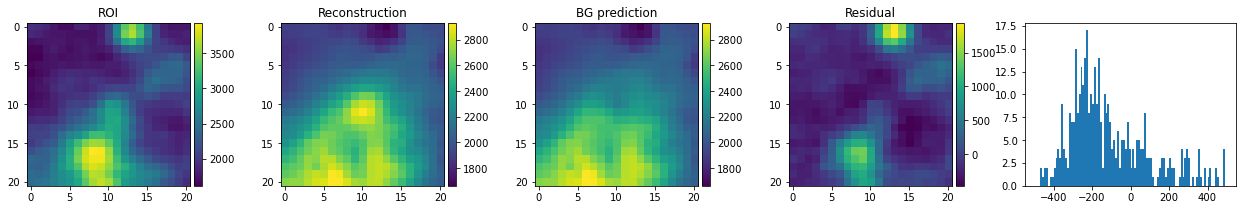

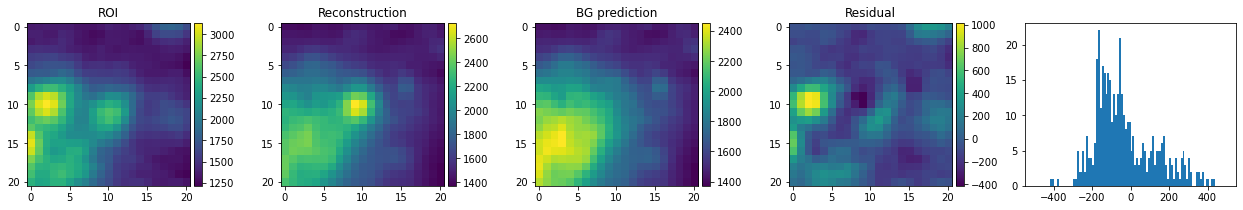

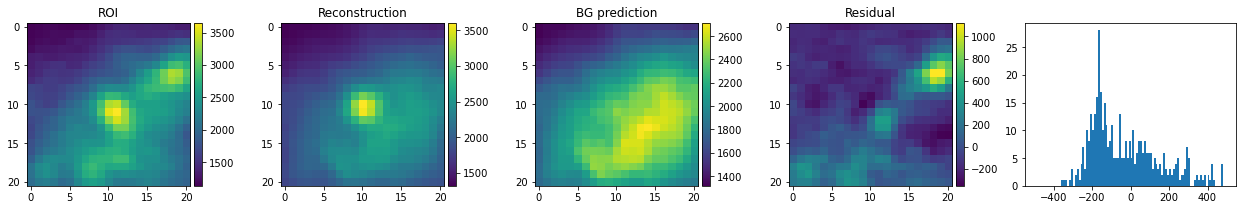

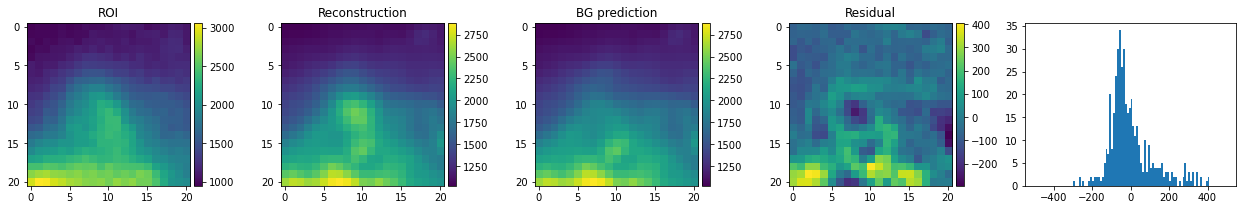

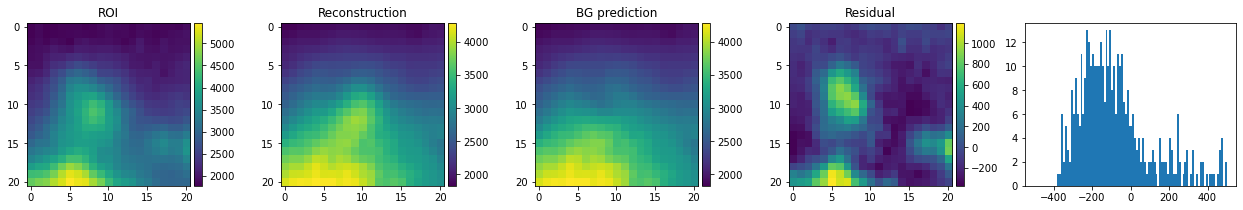

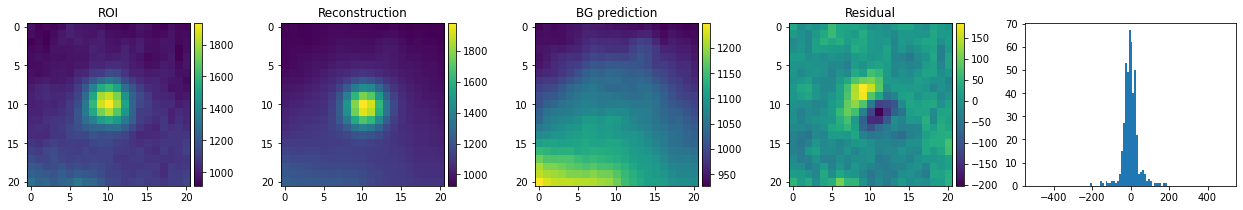

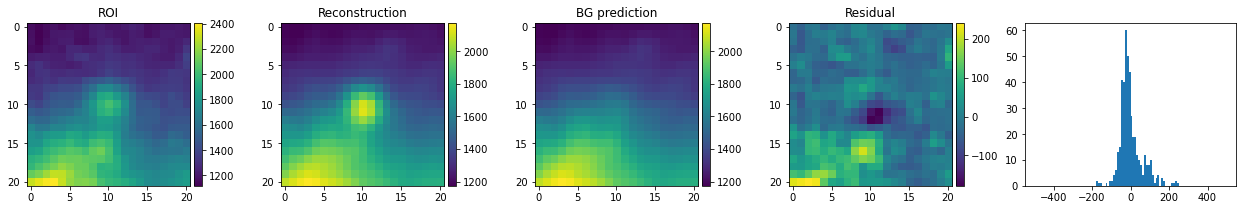

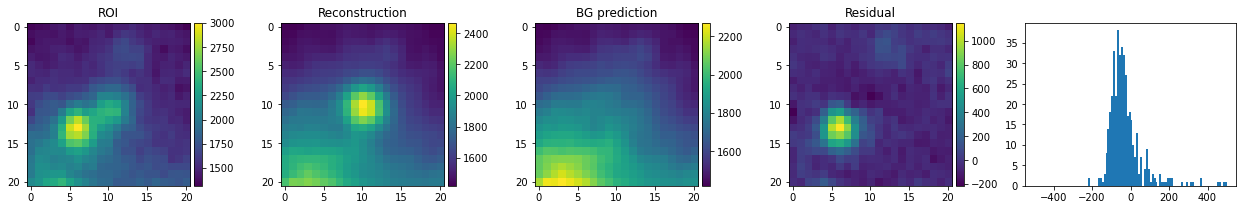

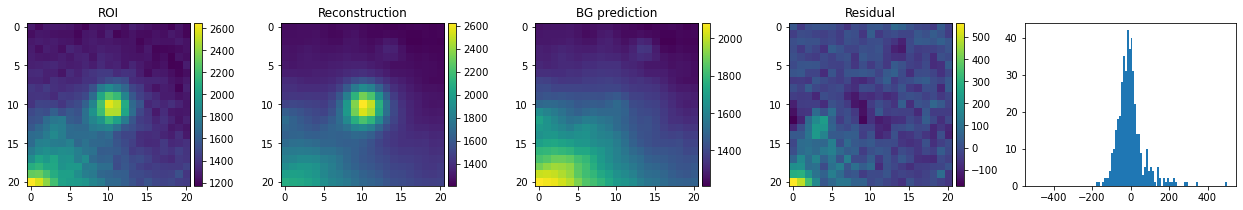

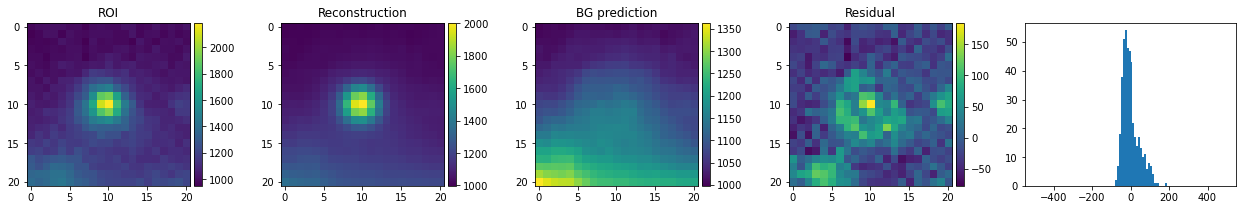

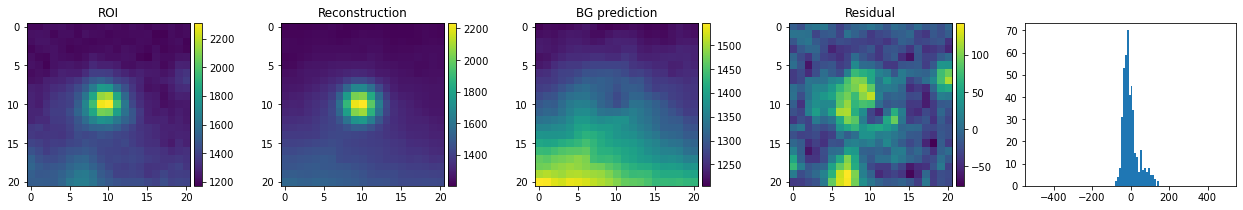

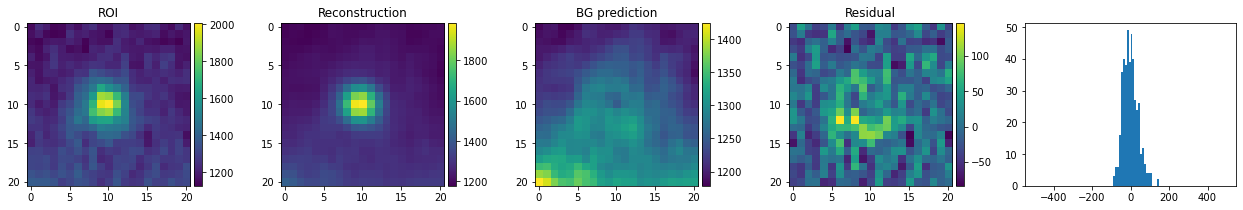

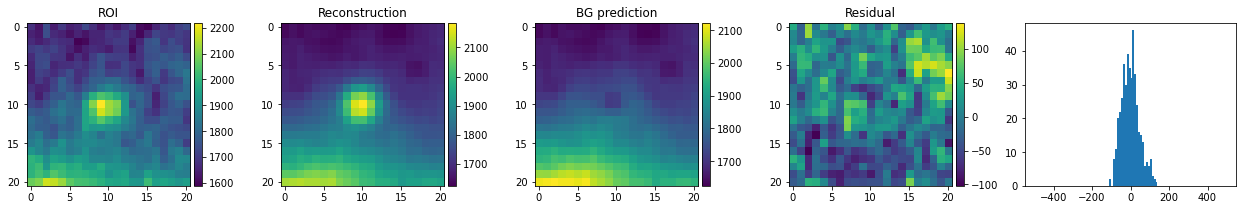

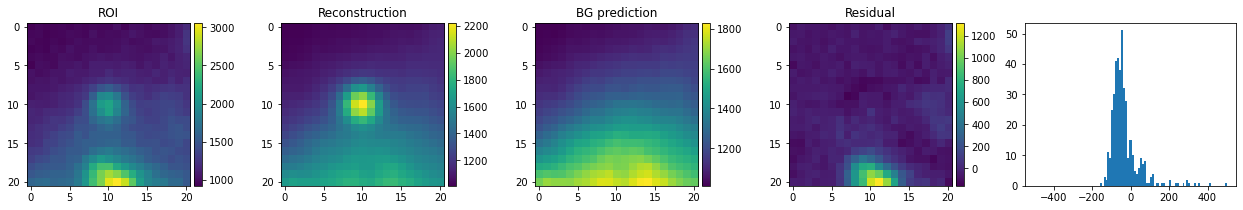

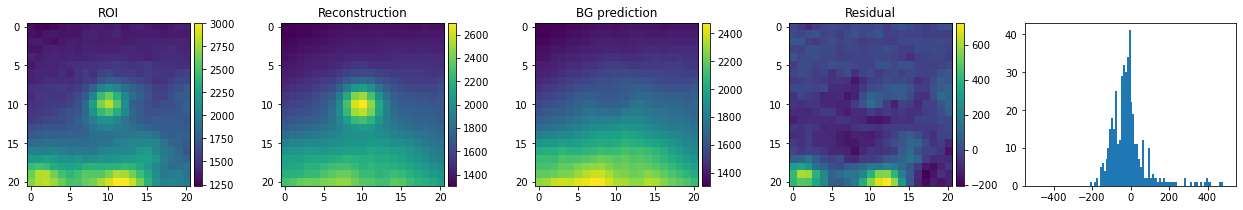

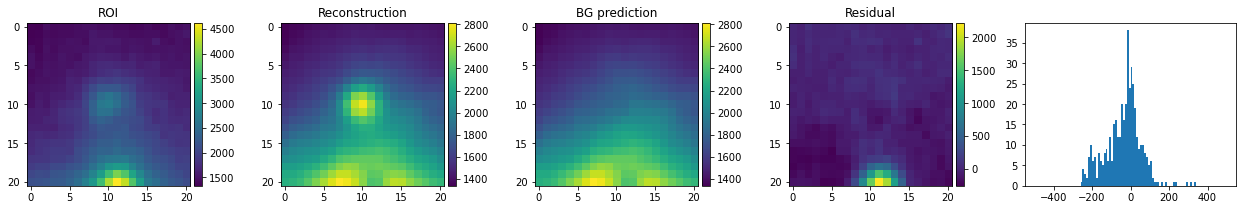

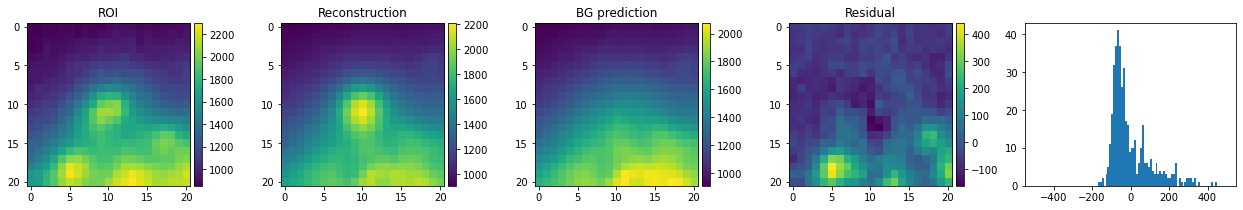

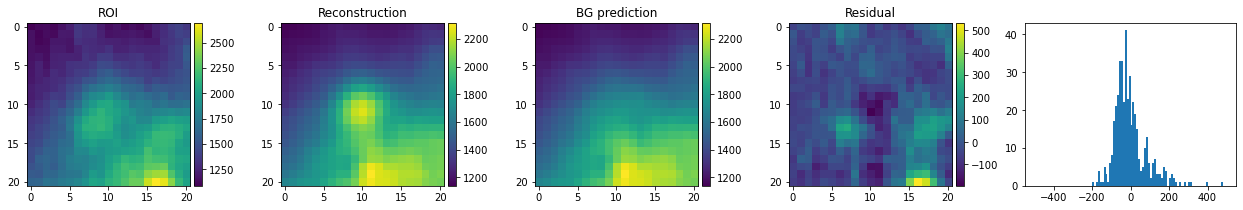

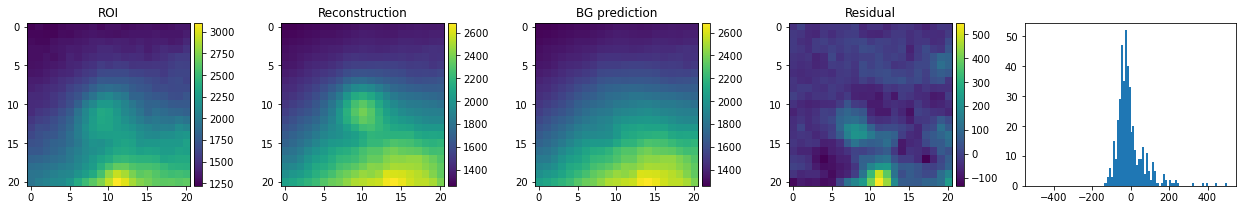

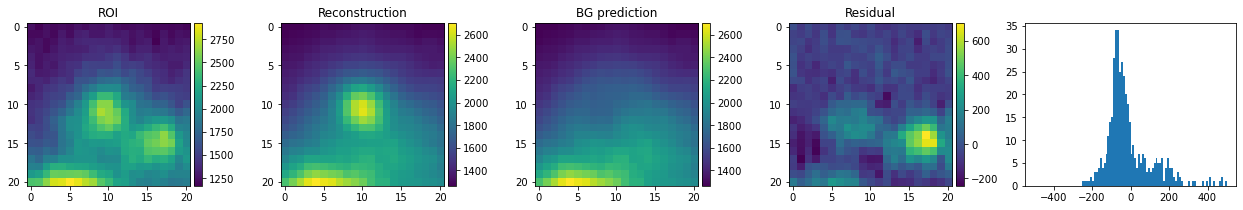

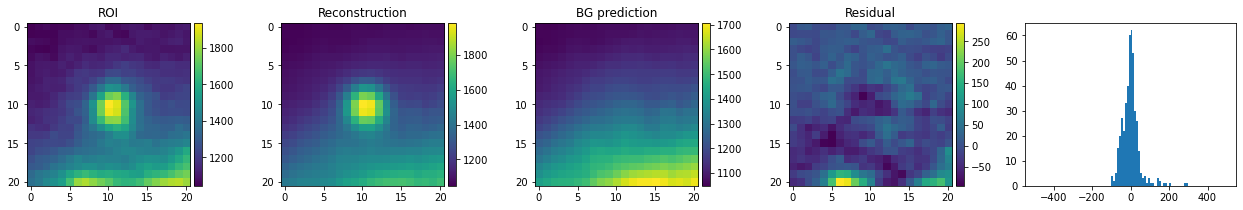

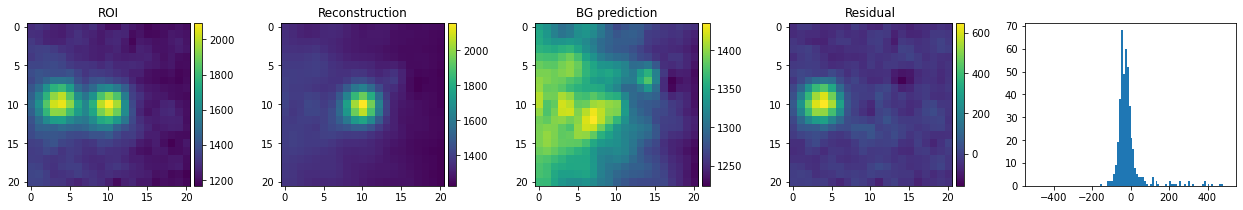

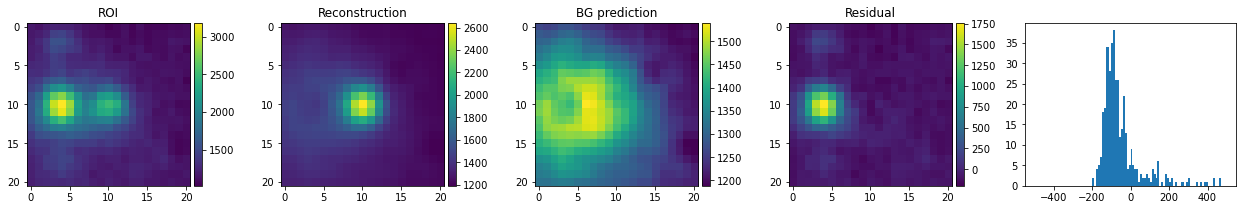

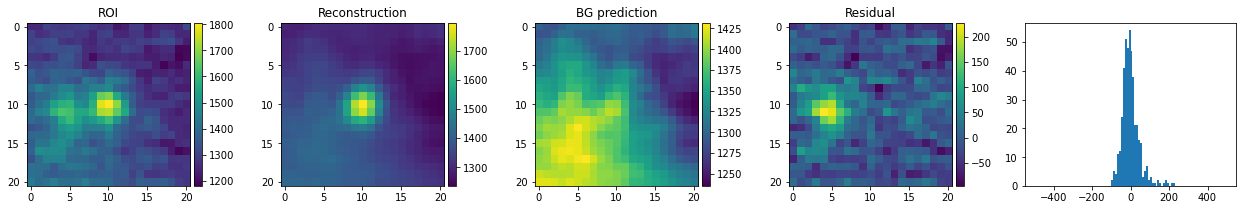

In [ ]:
for i in range(50,100):
    plt.figure(figsize=(22,3))
    plt.subplot(151)
    im = plt.imshow(cpu(rois)[i,0,0])
    add_colorbar(im)
    plt.title('ROI')
    plt.subplot(152)
    im = plt.imshow(cpu(psf_recs+bgs)[i,0,0])
#     im = plt.imshow((cpu(rois)-cpu(bgs_gt))[i,0,0])
    add_colorbar(im)
    plt.title('Reconstruction')
    plt.subplot(153)
    im = plt.imshow(cpu(bgs)[i,0,0])
    add_colorbar(im)
    plt.title('BG prediction')
    plt.subplot(154)
    im = plt.imshow(cpu(rois - psf_recs - bgs)[i,0,0])
    add_colorbar(im)
    plt.title('Residual')
    plt.subplot(155)
    plt.hist(cpu(rois - psf_recs - bgs)[i,0,0].reshape(-1), np.linspace(-500,500,101))
    plt.show()

In [ ]:
#export 
def gen_train_dataset(cfg,
          microscope,
          rois, 
          bgs,
          proc_out_inp,
          filt_inds,
          optim_dict):
    
    save_dir = Path(cfg.output.save_dir)
    
    # Save initial psf state
    torch.save(microscope.psf.state_dict(), str(save_dir) + '/psf_init.pkl' )

    # Controls which genmodel parameters are optimized
    for name, p in microscope.named_parameters(recurse=False):
        p.requires_grad = cfg.training.mic.par_grads[name]
    for name, p in microscope.psf.named_parameters():
        p.requires_grad = False  
    calc_log_p_x = False
    
    for batch_idx in range(cfg.training.start_iter, cfg.training.num_iters+1):

        optim_dict['optim_mic'].zero_grad()
        calc_log_p_x = False

        ch_out_inp = microscope.get_single_ch_inputs(*proc_out_inp, ycrop=None, xcrop=None)
        ch_out_inp = mic_inp_apply_inds(*ch_out_inp, filt_inds)
        
        psf_recs = microscope(*ch_out_inp, ret_psfs=True, add_noise=False)  
        
        mean_diff = 0.
        if cfg.training.mic.mean_diff:
            mean_diff = rois.mean([1,2,3,4], keepdim=True) - (psf_recs.detach()+bgs).mean([1,2,3,4], keepdim=True)
            
        if cfg.training.mic.edge_diff:
            bg_edges = torch.cat([bgs[:,0,0,:2,:].flatten(1,2), bgs[:,0,0,-2:,:].flatten(1,2), bgs[:,0,0,:,:2].flatten(1,2), bgs[:,0,0,:,-2:].flatten(1,2)], 1)
            rois_edges = torch.cat([rois[:,0,0,:2,:].flatten(1,2), rois[:,0,0,-2:,:].flatten(1,2), rois[:,0,0,:,:2].flatten(1,2), rois[:,0,0,:,-2:].flatten(1,2)], 1)
            mean_diff = (rois_edges.mean(-1) - bg_edges.mean(-1))[:,None,None,None,None]

        log_p_x_given_z = -microscope.noise(psf_recs, bgs, const_theta_sim=False, ch_inds=ch_out_inp[0][1]).log_prob((rois-mean_diff).clamp_min_(1.))

        log_p_x_given_z = log_p_x_given_z.mean()
        calc_log_p_x = True

#         log_p_x_given_z += ch_fac_loss

        if cfg.training.mic.norm_reg:
            log_p_x_given_z += cfg.training.mic.norm_reg * (microscope.psf.com_loss())

        if cfg.training.mic.l1_reg:
            log_p_x_given_z += cfg.training.mic.l1_reg * (microscope.psf.l1_diff_norm(microscope.psf_init_vol))  

        log_p_x_given_z.backward()
        if cfg.training.mic.grad_clip:
            torch.nn.utils.clip_grad_norm_(microscope.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)

        optim_dict['optim_mic'].step()
        optim_dict['sched_mic'].step()

        # Logging
        if batch_idx % cfg.output.log_interval == 0:

#             print(batch_idx, log_p_x_given_z)
            wandb.log({'AE Losses/p_x_given_z': log_p_x_given_z.detach().cpu()}, step=batch_idx)
            wandb.log({'AE Losses/RMSE(rec)': torch.sqrt((((rois-mean_diff)-(psf_recs+bgs))**2).mean()).detach().cpu()}, step=batch_idx)
            wandb.log({'AE Losses/sum(psf)': F.relu(microscope.psf.psf_volume)[0].sum().detach().cpu()}, step=batch_idx)
            
            torch.save(microscope.state_dict(), save_dir/'microscope.pkl')

    wandb.finish()    

In [ ]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_5_osb/sl_true_gen/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_31/target_mean:True//train.yaml')
cfg.run_name = 'base'
cfg.output.group = 'gensweep_mop_1'

cfg.output.log_interval = 20
cfg.training.bs = 150
cfg.genm.microscope.norm='none'

cfg.training.net.enabled = False

cfg.training.mic.edge_diff = False
cfg.training.mic.mean_diff = True

# cfg.data_path.image_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_5_osb/images.tiff'
# cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/MF_psf_07_20.tif'

cfg.data_path.model_init = f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_31/target_mean:True//checkpoint/'
cfg.data_path.micro_init = f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_31/target_mean:True//checkpoint/'
cfg.training.num_iters = 3000
cfg.training.schedule = None
cfg.training.mic.enabled = True

cfg.training.mic.l1_reg = 0.0003
cfg.training.mic.opt.lr = 0.00025

In [ ]:
fname = f'../config/experiment/{cfg.run_name}.yaml'
OmegaConf.save(cfg, fname)
prepend_line(fname, '# @package _global_')
cfg.run_name

'base'

In [ ]:
cfg.training.mic.par_grads.channel_facs = False
cfg.training.mic.par_grads.channel_shifts = True
cfg.training.mic.par_grads.theta_par = False
cfg.training.mic.par_grads.psf_vol = False
cfg.training.mic.par_grads.color_shifts = False
cfg.training.mic.par_grads.z_facs = False

In [ ]:
psf, noise, micro = load_psf_noise_micro(cfg)
post_proc = hydra.utils.instantiate(cfg.post_proc_isi)
codebook, targets = hydra.utils.instantiate(cfg.codebook)
# post_proc.codebook = torch.tensor(codebook)
post_proc.codebook = torch.tensor(expand_codebook(torch.tensor(codebook)))

In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
7 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
model = hydra.utils.instantiate(cfg.network)

psf  .to('cuda')
model.to('cuda')
micro.to('cuda')

Microscope(
  (psf): LinearInterpolatedPSF(
    (forward_nonlin): Identity()
  )
  (noise): GammaNoise()
)

In [ ]:
# Resume training from a previous checkpoint
if cfg.data_path.micro_init is not None:
    micro.load_state_dict(torch.load(Path(cfg.data_path.model_init)/'microscope.pkl'), strict=False)
    
if cfg.data_path.model_init is not None:
    print('loading')
    model = load_model_state(model, Path(cfg.data_path.model_init)/'model.pkl').cuda()

loading


In [ ]:
gt_channel_shifts = micro.channel_shifts.detach() + 0

0.947296802213191
0.9617171705732392
0.0618097650269464


Text(0.5, 0, 'Round')

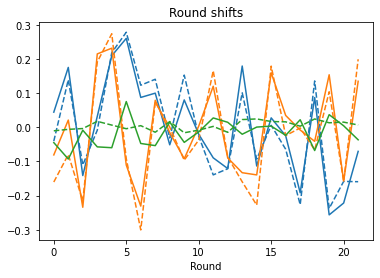

In [ ]:
import seaborn as sns
labels = ['x','y','z']
cmap = sns.color_palette("tab10")
for i in range(0,3):
    plt.plot(cpu(micro.channel_shifts[:,i]), label=labels[i], color=cmap[i])
    plt.plot(cpu(gt_channel_shifts[:,i]), label=labels[i], linestyle='--', color=cmap[i])
    print(np.corrcoef(cpu(micro.channel_shifts[:,i]), cpu(gt_channel_shifts[:,i]))[0,1])
plt.title('Round shifts')
plt.xlabel('Round')

In [ ]:
print(np.corrcoef(cpu(micro.channel_shifts[:,2]), cpu(gt_channel_shifts[:,0]))[0,1])

-0.38674272489429645


In [ ]:
state_dict = micro.state_dict()
ch_shifts = torch.randn(micro.channel_shifts.shape) * 0.
state_dict['channel_shifts'] = ch_shifts
micro.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# psf = get_vol_psf('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/MF_psf_07_20.tif', device='cuda', psf_extent_zyx=None, n_cols=1)
# micro.psf = psf
# micro.register_parameter(name='psf_vol', param=micro.psf.psf_volume)

In [ ]:
micro.psf_init_vol = micro.psf.psf_volume.detach() + 0

In [ ]:
optim_dict = {}
optim_dict['optim_mic'] = hydra.utils.instantiate(cfg.training.mic.opt, params=micro.parameters())
optim_dict['sched_mic'] = hydra.utils.instantiate(cfg.training.mic.sched, optimizer=optim_dict['optim_mic'])
    
save_dir = Path(cfg.output.save_dir)
save_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
_ = wandb.init(project=cfg.output.project, 
               config=OmegaConf.to_container(cfg, resolve=True),
               dir=cfg.output.log_dir,
               group=cfg.output.group,
               name=cfg.run_name,
               mode='online'
          )

AE Losses/RMSE(rec),██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
AE Losses/p_x_given_z,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
AE Losses/sum(psf),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AE Losses/RMSE(rec),268.18918
AE Losses/p_x_given_z,14.69183
AE Losses/sum(psf),7.0


2022-06-04 05:13:29.663804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
gen_train_dataset(cfg,
                  micro,
                  rois, 
                  bgs,
                  proc_out_inp,
                  filt_inds,
                  optim_dict)

AE Losses/RMSE(rec),█▇▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AE Losses/p_x_given_z,█▇▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AE Losses/sum(psf),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AE Losses/RMSE(rec),268.05344
AE Losses/p_x_given_z,14.68355
AE Losses/sum(psf),7.0


In [ ]:
gt_psf = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/chall_ds_psf_onesided_normed.tif')/gt_psf.max()

In [ ]:
def plot_slice_psf_pars(micro, gt_psf=False, figsize=[32,16]):
    
    psf_vol = cpu(micro.psf.psf_volume)
    psf_init = cpu(micro.psf_init_vol)
    
    psf_diff = psf_vol - psf_init
    n_sl = psf_init.shape[1]
    mid_px = psf_init.shape[-1]//2

    f, axes = plt.subplots(2 + 2 * micro.psf.n_cols + 1 if gt_psf is not None else 0, n_sl, sharey=False, figsize=figsize)

    for z in range(n_sl):

        vmax_z = psf_vol[0:,z].max()
        im = axes[0,z].imshow(psf_init[0,z], vmax=None)
        add_colorbar(im)
        axes[0,z].set_axis_off()
        axes[0,z].margins(x=0, y=0, tight=True)

        axes[-1, z].plot(psf_init[0,z,mid_px], label='Init.')
        axes[-1, z].set_axis_off()

        for n in range(micro.psf.n_cols):

            im = axes[1+2*n,z].imshow(psf_vol[n,z], vmax=None, vmin=0)
            add_colorbar(im)
            axes[1+2*n,z].set_axis_off()
            axes[1+2*n,z].margins(x=0, y=0, tight=True)

            im = axes[2+2*n,z].imshow(psf_diff[n,z], vmax=psf_diff.max(), vmin=psf_diff.min())
            add_colorbar(im)
            axes[2+2*n,z].set_axis_off()
            axes[2+2*n,z].margins(x=0, y=0, tight=True)

            axes[-1, z].plot(psf_vol[n,z,mid_px], label=f'col {n}')
            
        if gt_psf is not None:
            
            if z < len(gt_psf[0]):
                im = axes[-2, z].imshow(gt_psf[n,z], vmax=None, vmin=0)
                add_colorbar(im)
                axes[-1, z].plot(gt_psf[n,z,mid_px], label='gt')

    axes[-1, 0].legend(frameon=False)
    axes[0,0].set_title('Initial PSF', loc='left')
    axes[-1,0].set_title(f'Intensity profile', loc='left')
    for n in range(micro.psf.n_cols):
        axes[1+2*n,0].set_title(f'Learned PSF col. {n}', loc='left')
        axes[2+2*n,0].set_title(f'Diff.', loc='left')
        
    if gt_psf is not None:
        axes[-2,0].set_title('GT PSF', loc='left')

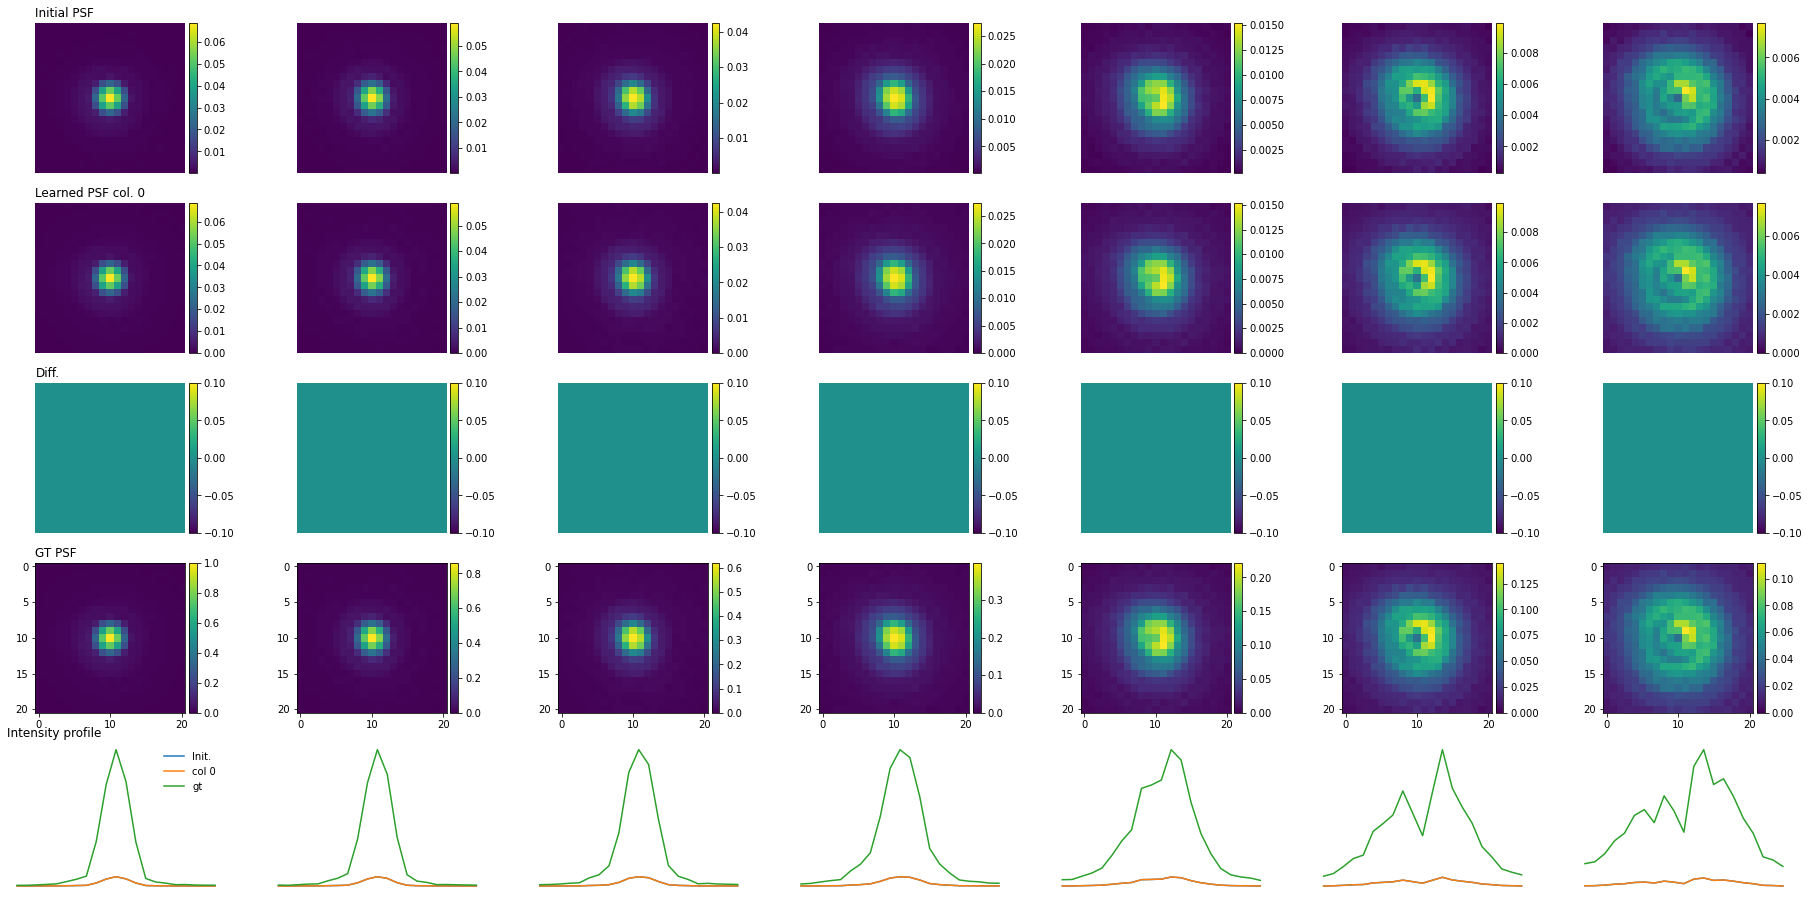

In [ ]:
# from decode_fish.funcs.visualization import *
plot_slice_psf_pars(micro, gt_psf[None])

In [ ]:
!nbdev_build_lib